In [24]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import glob
import math
import seaborn as sns


IMG_DIR = "/Volumes/256 GB/archive/ISIC2018_Task1-2_Training_Input"
MASK_DIR = "/Volumes/256 GB/archive/ISIC2018_Task1_Training_GroundTruth"
IMG_EXT, MASK_EXT = ".jpg", ".png"

print("Папка изображений:", IMG_DIR)
print("Папка масок:", MASK_DIR)

img_paths = sorted(glob.glob(os.path.join(IMG_DIR, f"*{IMG_EXT}")))
mask_paths = sorted(glob.glob(os.path.join(MASK_DIR, f"*{MASK_EXT}")))

print(f"Всего изображений: {len(img_paths)}, масок: {len(mask_paths)}")

def normalize_mask_id(path):
    name = os.path.splitext(os.path.basename(path))[0]
    return name.replace("_segmentation", "")

img_ids = [os.path.splitext(os.path.basename(p))[0] for p in img_paths]
mask_ids = [normalize_mask_id(p) for p in mask_paths]
common_ids = sorted(set(img_ids).intersection(set(mask_ids)))
print(f"Совпадающих пар изображение–маска: {len(common_ids)}")

Папка изображений: /Volumes/256 GB/archive/ISIC2018_Task1-2_Training_Input
Папка масок: /Volumes/256 GB/archive/ISIC2018_Task1_Training_GroundTruth
Всего изображений: 2594, масок: 2594
Совпадающих пар изображение–маска: 2594


In [25]:
records = []
for iid in common_ids:
    ip = os.path.join(IMG_DIR, iid + IMG_EXT)
    mp = os.path.join(MASK_DIR, iid + "_segmentation" + MASK_EXT)
    row = {"image_id": iid, "img_exists": os.path.exists(ip), "mask_exists": os.path.exists(mp)}
    if row["img_exists"]:
        with Image.open(ip) as im:
            row["width"], row["height"] = im.size
            row["aspect"] = row["width"] / row["height"]
    if row["mask_exists"]:
        m = np.array(Image.open(mp).convert("L"))
        binary = (m > 127).astype(np.uint8)
        row["mask_area_pct"] = 100 * binary.sum() / (binary.size + 1e-9)
        row["mask_nonbinary_px"] = int(((m != 0) & (m != 255)).sum())
        row["img_mask_same_size"] = (m.shape[1] == row["width"]) and (m.shape[0] == row["height"])
    records.append(row)

df_eda = pd.DataFrame(records)
display(df_eda.head())
display(df_eda.describe(include="all"))

,image_id,img_exists,mask_exists,width,height,aspect,mask_area_pct,mask_nonbinary_px,img_mask_same_size
0,ISIC_0000000,True,True,1022,767,1.332464,46.973238,0,True
1,ISIC_0000001,True,True,1022,767,1.332464,7.050368,0,True
2,ISIC_0000003,True,True,1022,767,1.332464,33.656940,0,True
3,ISIC_0000004,True,True,1022,767,1.332464,34.497381,0,True
4,ISIC_0000006,True,True,1022,767,1.332464,9.172265,0,True


,image_id,img_exists,mask_exists,width,height,aspect,mask_area_pct,mask_nonbinary_px,img_mask_same_size
count,2594,2594,2594,2594.000000,2594.000000,2594.000000,2594.000000,2594.0,2594
unique,2594,1,1,NaN,NaN,NaN,NaN,NaN,1
top,ISIC_0000000,True,True,NaN,NaN,NaN,NaN,NaN,True
freq,1,2594,2594,NaN,NaN,NaN,NaN,NaN,2594
mean,NaN,NaN,NaN,3188.266384,2166.791442,1.431942,21.402130,0.0,NaN
std,NaN,NaN,NaN,1923.091567,1241.344101,0.100596,20.836574,0.0,NaN
min,NaN,NaN,NaN,576.000000,540.000000,0.750000,0.297673,0.0,NaN
25%,NaN,NaN,NaN,1024.000000,768.000000,1.333333,5.173061,0.0,NaN
50%,NaN,NaN,NaN,3008.000000,2000.000000,1.500000,13.808378,0.0,NaN
75%,NaN,NaN,NaN,4288.000000,2848.000000,1.505618,31.873311,0.0,NaN


In [26]:
missing_report = df_eda.isna().sum().sort_values(ascending=False).to_frame("missing_count")
missing_report["missing_share_%"] = 100 * missing_report["missing_count"] / len(df_eda)
display(missing_report)

print("Нет изображения:", (~df_eda["img_exists"]).sum())
print("Нет маски:", (~df_eda["mask_exists"]).sum())
print("Пустых масок:", (df_eda["mask_area_pct"].fillna(0) == 0).sum())
print("Несовпадает размер img vs mask:", (~df_eda["img_mask_same_size"].fillna(True)).sum())
print("Небинарные маски (есть пиксели != {0,255}):", (df_eda["mask_nonbinary_px"].fillna(0) > 0).sum())

clean = df_eda[
    (df_eda["img_exists"]) &
    (df_eda["mask_exists"]) &
    (df_eda["img_mask_same_size"] == True) &
    (df_eda["mask_nonbinary_px"].fillna(0) == 0)
].copy()
print("Чистых пар для обучения:", len(clean), "из", len(df_eda))

,missing_count,missing_share_%
image_id,0,0.0
img_exists,0,0.0
mask_exists,0,0.0
width,0,0.0
height,0,0.0
aspect,0,0.0
mask_area_pct,0,0.0
mask_nonbinary_px,0,0.0
img_mask_same_size,0,0.0


Нет изображения: 0
Нет маски: 0
Пустых масок: 0
Несовпадает размер img vs mask: 0
Небинарные маски (есть пиксели != {0,255}): 0
Чистых пар для обучения: 2594 из 2594


Выбросы по width: 0 (границы -3872.00 .. 9184.00)
Выбросы по height: 0 (границы -2352.00 .. 5968.00)
Выбросы по aspect: 11 (границы 1.07 .. 1.76)
Выбросы по mask_area_pct: 95 (границы -34.88 .. 71.92)


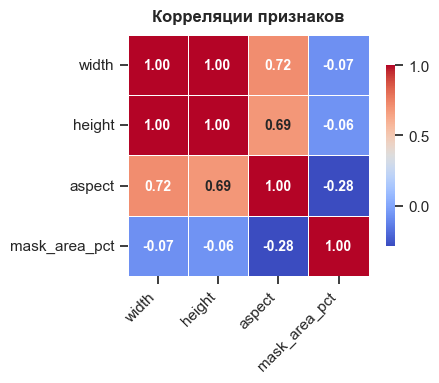

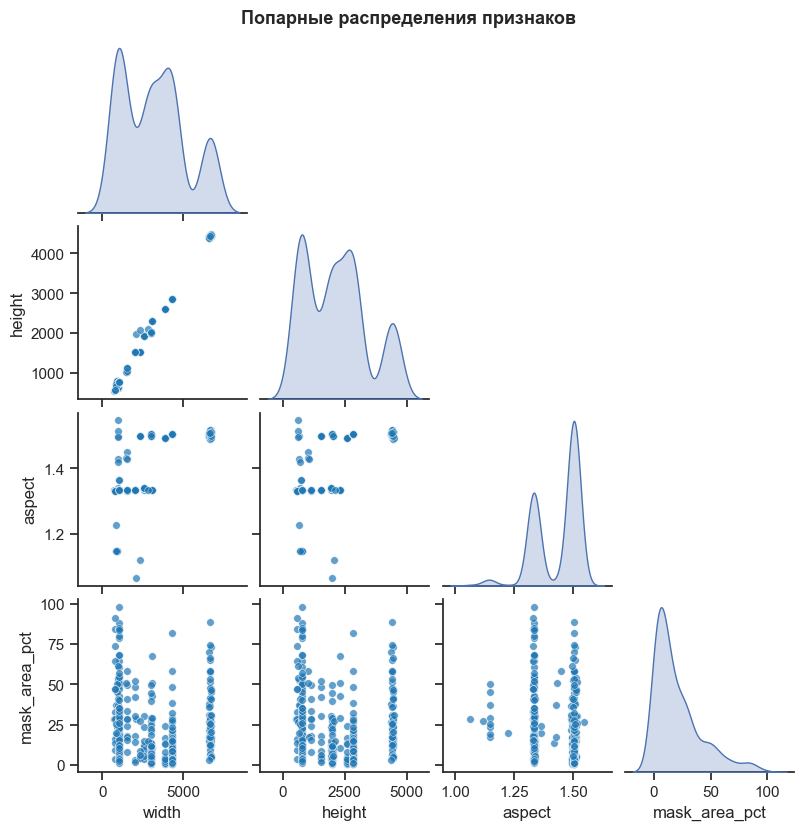

In [27]:
def iqr_flags(s, k=1.5):
    q1, q3 = np.nanpercentile(s, [25, 75])
    iqr = q3 - q1
    low, high = q1 - k * iqr, q3 + k * iqr
    return (s < low) | (s > high), (low, high)

for col in ["width", "height", "aspect", "mask_area_pct"]:
    flags, bounds = iqr_flags(clean[col].astype(float), k=1.5)
    n_out = int(flags.sum())
    print(f"Выбросы по {col}: {n_out} (границы {bounds[0]:.2f} .. {bounds[1]:.2f})")

num_cols = ["width", "height", "aspect", "mask_area_pct"]
corr = clean[num_cols].corr()

plt.figure(figsize=(5, 4))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    cbar_kws={"shrink": 0.75},
    linewidths=0.5,
    annot_kws={"size": 10, "weight": "bold"},
)
plt.title("Корреляции признаков", fontsize=12, fontweight="bold", pad=10)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

sns.set_theme(style="ticks")
pp = sns.pairplot(
    clean.sample(min(400, len(clean))),
    vars=num_cols,
    diag_kind="kde",
    corner=True,
    plot_kws={"s": 30, "alpha": 0.7, "color": "#1f77b4"},
)
pp.fig.suptitle("Попарные распределения признаков", y=1.02, fontsize=13, fontweight="bold")
pp.fig.set_size_inches(8, 8)
plt.show()

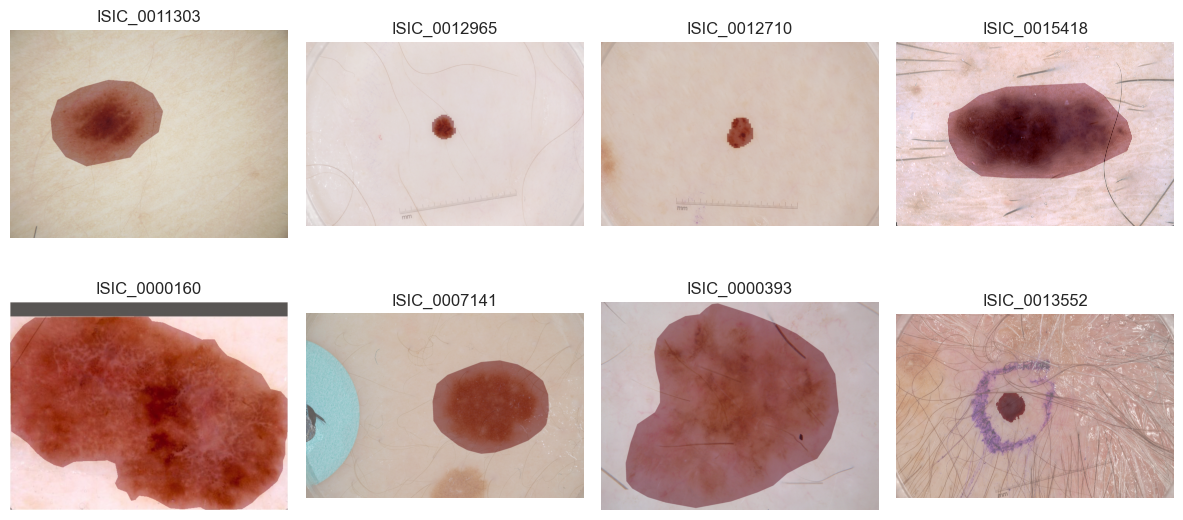

In [28]:
def show_examples(ids, ncols=4, alpha=0.35):
    n = len(ids)
    nrows = math.ceil(n / ncols)
    plt.figure(figsize=(3*ncols, 3*nrows))
    for i, iid in enumerate(ids):
        ip = os.path.join(IMG_DIR, iid + IMG_EXT)
        mp = os.path.join(MASK_DIR, iid + "_segmentation" + MASK_EXT)
        if not os.path.exists(ip) or not os.path.exists(mp):
            continue
        img = np.array(Image.open(ip).convert("RGB"))
        msk = np.array(Image.open(mp).convert("L"))
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(img)
        plt.imshow(msk, alpha=alpha, cmap="Reds")
        plt.axis("off")
        plt.title(iid)
    plt.tight_layout()
    plt.show()

show_examples(random.sample(list(clean["image_id"]), 8))

In [29]:
n_images = len(img_paths)
n_masks = len(mask_paths)
n_pairs = len(common_ids)
mean_w, mean_h = np.mean(clean["width"]), np.mean(clean["height"])
mean_mask_area = np.mean(clean["mask_area_pct"])
min_mask_area, max_mask_area = np.min(clean["mask_area_pct"]), np.max(clean["mask_area_pct"])
num_empty = (clean["mask_area_pct"] == 0).sum()
resize_target = 512 if max(mean_w, mean_h) > 600 else 224

if mean_mask_area < 5:
    lesion_comment = "Большинство поражений занимают малую часть кадра (<5%), модель должна быть чувствительной к мелким объектам."
elif mean_mask_area < 20:
    lesion_comment = "Поражения занимают умеренную часть кадра (5–20%), наблюдается дисбаланс по размерам."
else:
    lesion_comment = "Поражения крупные, занимают значительную часть изображения (>20%)."

report = f"""
📊 **Выводы EDA**

1. В датасете обнаружено **{n_images:,} изображений** и **{n_masks:,} масок**.  
   Совпадающих пар изображение–маска: **{n_pairs:,}**.  
2. Средний размер изображений: **{int(mean_w)}×{int(mean_h)} px**.  
   Рекомендуется ресайз до **{resize_target}×{resize_target} px** для единообразия.  
3. Средняя площадь поражений: **{mean_mask_area:.2f}%** (min {min_mask_area:.2f}%, max {max_mask_area:.2f}%).  
   {lesion_comment}  
4. Найдено **{num_empty} пустых** масок — вероятные аномалии разметки.  
5. Метрики: **IoU (Jaccard)** и **Dice coefficient**; потери: **BCE + Dice**.  
6. Датасет подготовлен локально и готов к использованию в обучении моделей сегментации.
"""

from IPython.display import Markdown
display(Markdown(report))


📊 **Выводы EDA**

1. В датасете обнаружено **2,594 изображений** и **2,594 масок**.  
   Совпадающих пар изображение–маска: **2,594**.  
2. Средний размер изображений: **3188×2166 px**.  
   Рекомендуется ресайз до **512×512 px** для единообразия.  
3. Средняя площадь поражений: **21.40%** (min 0.30%, max 98.66%).  
   Поражения крупные, занимают значительную часть изображения (>20%).  
4. Найдено **0 пустых** масок — вероятные аномалии разметки.  
5. Метрики: **IoU (Jaccard)** и **Dice coefficient**; потери: **BCE + Dice**.  
6. Датасет подготовлен локально и готов к использованию в обучении моделей сегментации.
